In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from feature_engine.selection import DropFeatures
from feature_engine.creation import CombineWithReferenceFeature
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    plot_roc_curve,
)
import warnings


# Config
%matplotlib inline
%load_ext nb_black
%load_ext lab_black
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

<IPython.core.display.Javascript object>

In [2]:
X_train = pd.read_csv("../data/raw/train.csv")
X_test = pd.read_csv("../data/raw/test.csv")

<IPython.core.display.Javascript object>

In [3]:
X_train["Churn"] = X_train["Churn"].map({"Yes": 1, "No": 0})
X_test["Churn"] = X_test["Churn"].map({"Yes": 1, "No": 0})

<IPython.core.display.Javascript object>

In [4]:
def casting_numerical(dataframe, numerical_feature):
    """Cast features to the correct type."""
    dataframe[numerical_feature] = dataframe[numerical_feature].apply(
        lambda dataframe: str(dataframe).replace(",", "."),
    )
    dataframe[numerical_feature] = pd.to_numeric(
        dataframe[numerical_feature], errors="coerce"
    )
    dataframe[numerical_feature] = dataframe[numerical_feature].astype("float64")
    dataframe[numerical_feature] = dataframe[numerical_feature].replace("", np.nan)
    return dataframe


def casting_categorical(dataframe, categorical_feature):
    """Cast features to the correct type."""
    dataframe[categorical_feature] = dataframe[categorical_feature].astype("object")
    return dataframe


def change_no_service_to_no(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtype == "object":
            dataframe[col] = dataframe[col].replace("No phone service", "No")
            dataframe[col] = dataframe[col].replace("No internet service", "No")
    return dataframe

<IPython.core.display.Javascript object>

In [5]:
# apply casting_numerical function to X_train and X_test simultaneously
X_train, X_test = map(
    lambda dataframe: casting_numerical(dataframe, "TotalCharges"),
    [X_train, X_test],
)

X_train, X_test = map(
    lambda dataframe: casting_categorical(dataframe, "SeniorCitizen"),
    [X_train, X_test],
)

X_train, X_test = map(
    lambda dataframe: change_no_service_to_no(dataframe),
    [X_train, X_test],
)

<IPython.core.display.Javascript object>

In [6]:
# dropna from X_train and X_test simultaneously
X_train, X_test = map(lambda dataframe: dataframe.dropna(), [X_train, X_test])

<IPython.core.display.Javascript object>

In [7]:
y_train = X_train["Churn"]
X_train = X_train.drop("Churn", axis=1)

y_test = X_test["Churn"]
X_test = X_test.drop("Churn", axis=1)

<IPython.core.display.Javascript object>

In [8]:
preprocessor = Pipeline(
    [
        ("drop_vars", DropFeatures(["customerID"])),
        (
            "tenure_combine",
            CombineWithReferenceFeature(
                variables_to_combine=["MonthlyCharges", "TotalCharges"],
                reference_variables=["tenure"],
                operations=["div"],
                new_variables_names=["tenureMonthlyRate", "tenureTotalRate"],
            ),
        ),
        (
            "totalcharges_combine",
            CombineWithReferenceFeature(
                variables_to_combine=["TotalCharges"],
                reference_variables=["MonthlyCharges"],
                operations=["div"],
                new_variables_names=["RateCharge"],
            ),
        ),
        (
            "preprocessor",
            ColumnTransformer(
                [
                    (
                        "num",
                        make_pipeline(
                            SimpleImputer(strategy="median"),
                        ),
                        make_column_selector(dtype_include=np.number),
                    ),
                    (
                        "cat",
                        make_pipeline(
                            SimpleImputer(strategy="most_frequent"),
                            TargetEncoder(),
                        ),
                        make_column_selector(dtype_include=["object"]),
                    ),
                ],
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [9]:
models = [
    ("LR", LogisticRegression(random_state=42)),
    ("rf", RandomForestClassifier(random_state=42)),
    ("et", ExtraTreesClassifier(random_state=42)),
    ("gb", GradientBoostingClassifier(random_state=42)),
    ("hgb", HistGradientBoostingClassifier(random_state=42)),
    ("lgbm", LGBMClassifier(random_state=42)),
    ("xgb", XGBClassifier(random_state=42)),
]

results = []
names = []

for name, model in models:
    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("model", model),
        ]
    )

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    scores = cross_val_score(
        pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1
    )
    results.append(scores)
    names.append(model)

    msg = "%s: %f (%f)" % (model, scores.mean(), scores.std())
    print(msg)

/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/

LogisticRegression(random_state=42): 0.809587 (0.017302)


/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/

RandomForestClassifier(random_state=42): 0.824263 (0.016234)


/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/

ExtraTreesClassifier(random_state=42): 0.808176 (0.017561)


/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/

GradientBoostingClassifier(random_state=42): 0.842435 (0.015467)


/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/

HistGradientBoostingClassifier(random_state=42): 0.829532 (0.015065)


/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/

LGBMClassifier(random_state=42): 0.828888 (0.016427)


/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...): 0.818615 (0.016324)


<IPython.core.display.Javascript object>

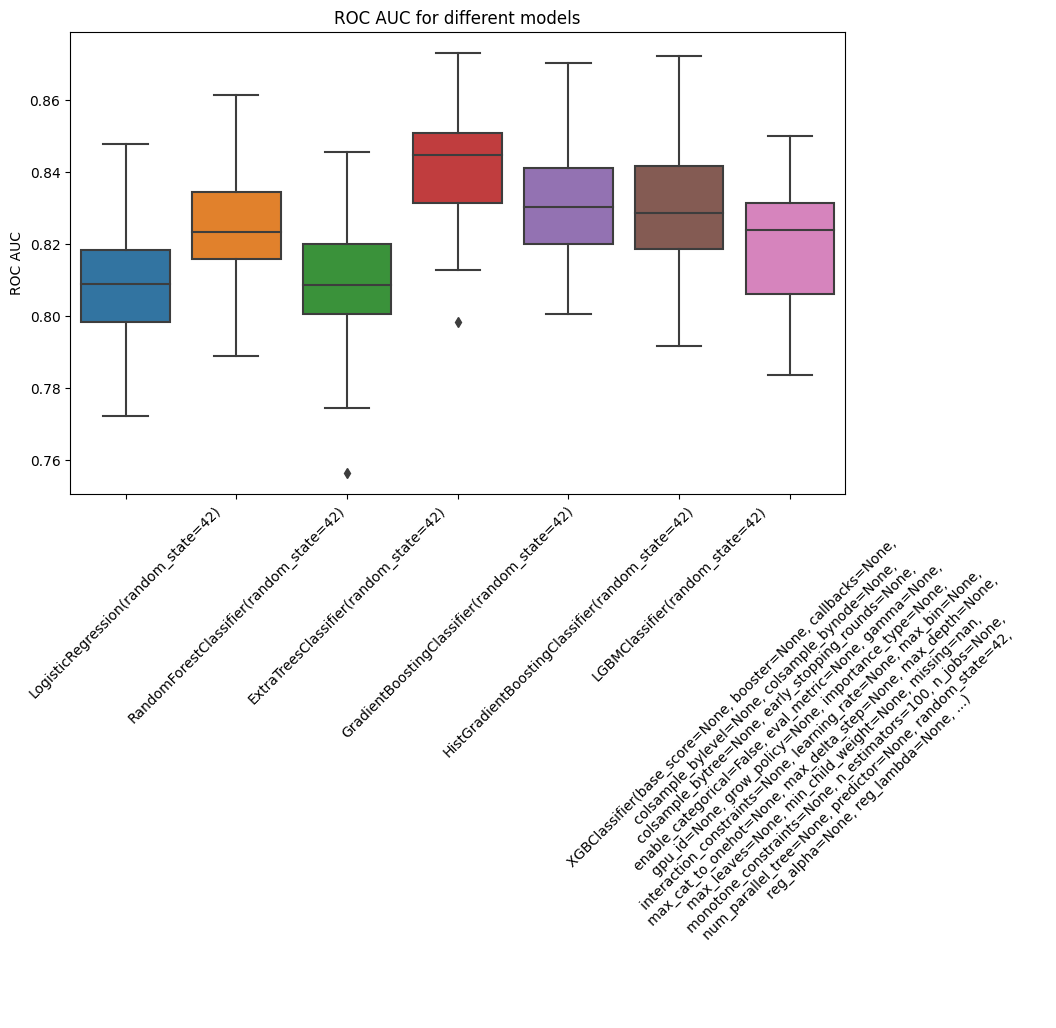

<IPython.core.display.Javascript object>

In [10]:
# turn names and results into a dataframe
models_df = pd.DataFrame(results).T
models_df.columns = names

# plot the results with seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=models_df, ax=ax)
ax.set_xticklabels(names, rotation=45)
ax.set_ylabel("ROC AUC")
ax.set_title("ROC AUC for different models")
plt.show()